In [1]:
# !pip install visdom

## Imports

### Standard Imports

In [2]:
from __future__ import print_function
from __future__ import division

from pprint import pprint
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts

import argparse
import copy
import datetime
import os
import random
import skimage
import shutil
import time
# import visdom
import warnings

### Torch imports

In [3]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize

## Setting Notebook

### Set seeds for repeatability

In [4]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


In [5]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_extract = True

### Custom Argparser

In [6]:
parser = argparse.ArgumentParser(description='PyTorch SirenNet Training')
"""parser.add_argument('data', metavar='DIR',
                    help='path to dataset')"""
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--gpu', default=None, type=int,
                    help='GPU id to use.')

_StoreAction(option_strings=['--gpu'], dest='gpu', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, help='GPU id to use.', metavar=None)

### Set device - either gpu:0 or cpu

In [7]:
# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = (torch.device('cuda:0') if torch.cuda.is_available()
    else torch.device('gpu'))
print(f"Training on device {device}.")
print(f"# cuda device: {torch.cuda.device_count()}")
print(f"Id current device: {torch.cuda.current_device()}")

Training on device cuda:0.
# cuda device: 1
Id current device: 0


## Siren Hyper-parameters

In [8]:
# Siren's architecture Hyper-params
in_features = 2
out_features = 1
sidelength = 128
hidden_layers = 3

# Training phase's Hyper-params
learning_rate = 1e-4

# Displaying Images
steps_til_summary = 10

image_path = "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68/test001.png"

## Functions

### Utils

In [9]:
def show_hist_kde_train_loss(bins = 10):
    samples = df['train_loss'].values
    n = len(samples)
    
    h, e = np.histogram(samples, bins=bins, density=True)
    x = np.linspace(e.min(), e.max())

    # plot the histogram
    plt.figure(figsize=(8,6))
    plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

    # plot the real KDE
    kde = sts.gaussian_kde(samples)
    plt.plot(x, kde.pdf(x), c='C1', lw=8, label='KDE')

    # resample the histogram and find the KDE.
    resamples = np.random.choice((e[:-1] + e[1:])/2, size=n*5, p=h/h.sum())
    rkde = sts.gaussian_kde(resamples)

    # plot the KDE
    plt.plot(x, rkde.pdf(x), '--', c='C3', lw=4, label='resampled KDE')
    plt.title('Train Loss: n = %d samples' % n)
    plt.legend()
    plt.show()
    pass

In [10]:
def printImageAttributes(imageObject, imagePath):

    # Retrieve the attributes of the image

    fileFormat      = imageObject.format        # Format of the image
    imageMode       = imageObject.mode          # Mode of the image
    imageSize       = imageObject.size          # Size of the image - tupe of (width, height)
    colorPalette    = imageObject.palette       # Palette used in the image

    # Print the attributes of the image
    print("Attributes of image:%s"%imagePath)

    print("The file format of the image is:%s"%fileFormat)

    print("The mode of the image is:%s"%imageMode)

    print("The size of the image is:width %d pixels,height %d pixels"%imageSize)

    print("Color palette used in image:%s"%colorPalette)

    print("Keys from image.info dictionary:%s")

    for key, value in imageObject.info.items() :
        print(key)
        print(value)
        pass
    pass

def get_cameraman_tensor(sidelength):
    # print(type(skimage.data.camera()))
    img = Image.fromarray(skimage.data.camera())
    
    # print(type(img))
    printImageAttributes(img, "cameraman")

    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [11]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [12]:
def get_model(in_features, out_features, hidden_features, hidden_layers):
    img_siren = Siren(
        in_features = in_features,
        out_features = out_features,
        hidden_features = hidden_features, 
        hidden_layers = hidden_layers,
        outermost_linear=True)
    img_siren.cuda()
    return img_siren

In [13]:
def get_information_model(model):
    model = model.to(device)

    numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
    print(model)
    print(sum(numel_list), numel_list)

    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    pass

### Trainining Loop: Show Image Estimate Progression

In [14]:
def show_images(model_output, coords):
    img_grad = gradient(model_output, coords)
    img_laplacian = laplace(model_output, coords)

    fig, axes = plt.subplots(1,3, figsize=(18,6))
    axes[0].imshow(model_output.cpu().view(sidelength, sidelength).detach().numpy())
    axes[1].imshow(img_grad.norm(dim=-1).cpu().view(sidelength, sidelength).detach().numpy())
    axes[2].imshow(img_laplacian.cpu().view(sidelength, sidelength).detach().numpy())
    plt.show()
    pass

def basic_traininig_loop(optimizer, criterion, model, model_input, ground_truth, total_steps, steps_til_summary = 10):
    
    train_acc_history = [] # val_acc_history = []
    train_loss_history = [] # val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())

    model.train()  # Set model to training mode

    for step in range(total_steps):
        # print('Epoch {}/{}'.format(step, total_steps - 1))
        # print('-' * 10)

        model_output, coords = model(model_input)
        loss = criterion(model_output, ground_truth)  
        # loss = ((model_output - ground_truth)**2).mean()
    
        if not step % steps_til_summary:
            print("Step %d, Total loss %0.6f" % (step, loss))
            show_images(model_output, coords)
            pass
        
        train_loss_history.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        best_model_wts = copy.deepcopy(model.state_dict())
        pass
    

    # load best model weights
    model.load_state_dict(best_model_wts)

    # create history as python dictionary
    keys_history_list = "train_loss".split(",")
    values_history_list = [train_loss_history]

    history = dict(zip(keys_history_list, values_history_list))

    return model, history

### Plane Training Loop

In [15]:
def plane_traininig_loop(optimizer, criterion, model, model_input, ground_truth, total_steps, verbose = 0):
    
    train_acc_history = [] # val_acc_history = []
    train_loss_history = [] # val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())

    model.train()  # Set model to training mode

    phase = 'train'
    for step in range(total_steps):
        if verbose == 1:
            print('Epoch {}/{}'.format(step, total_steps - 1))
            print('-' * 10)

        model_output, coords = model(model_input)    
        loss = criterion(model_output, ground_truth)
        # loss = ((model_output - ground_truth)**2).mean()
        
        if verbose == 1:
            print('{} Loss: {:.4f}'.format(phase, loss))
        train_loss_history.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        best_model_wts = copy.deepcopy(model.state_dict())
        pass
    

    # load best model weights
    model.load_state_dict(best_model_wts)

    # create history as python dictionary
    keys_history_list = "train_loss".split(",")
    values_history_list = [train_loss_history]

    history = dict(zip(keys_history_list, values_history_list))

    return model, history

### Training Loop: Run through a whole set of images

In [16]:
def a_training_loop(images, first_image_pos, last_image_pos, sidelength = 128, lr = 1e-4, total_steps = 500, verbose = 0):
    for _, image_path in enumerate(images[first_image_pos:last_image_pos]):

        # Create a DataLoader Instance for current image to be fitted
        # -------------------------------------------------------------------- #
        image = ImageFitting(
            sidelength,
            image_path = image_path)
        dataloader = DataLoader(image,
            batch_size=1,
            pin_memory=True,
            num_workers=0)

        img_siren = get_model(
            in_features = in_features,
            out_features = out_features,
            hidden_features = sidelength,
            hidden_layers = hidden_layers)

        # Establish Number of steps, criterion, and loss function
        # -------------------------------------------------------------------- #
        # total_steps = 500 
        # Since the whole image is our dataset, this just means 500 gradient descent steps.

        criterion = nn.MSELoss()
        optim = torch.optim.Adam(lr=lr, params=img_siren.parameters())

        model_input, ground_truth = next(iter(dataloader))
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

        # Proceed with training
        # -------------------------------------------------------------------- #
        start = time.time()
        # model, history = basic_traininig_loop(
        model, history = plane_traininig_loop(
            optimizer = optim,
            criterion = criterion,
            model = img_siren,
            model_input = model_input,
            ground_truth = ground_truth,
            # total_steps = total_steps, steps_til_summary = steps_til_summary)
            total_steps = total_steps)
        stop = time.time()

        # times = (stop - start) * 1000
        times = (stop - start)
        if verbose == 1:
            print('-' * 40)
            # print('Run time takes %d miliseconds' % times) # print('Run time takes %.3f seconds' % times)
            print('Training complete in {:.0f}m {:.0f}s {:.0f}ms'
                .format(times // 60, times % 60, (times - int((times % 60))) * 1000))

        # Save results for current trained image
        # -------------------------------------------------------------------- #
        image_name = os.path.basename(image_path)
        last_loss_train = history['train_loss'][-1]
        a_record = [image_name, last_loss_train.item(), times]

        records_list.append(a_record)
        pass
    return model, history, records_list

## Siren Classes

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [17]:
class ImageFitting(Dataset):
    def __init__(self, sidelength, image_path = None):
        super().__init__()
        if image_path is None:
            img = get_cameraman_tensor(sidelength)
        else:
            imag = Image.open(image_path)
            imag = imag.resize((sidelength, sidelength))
            # printImageAttributes(imag, image_path)
            # imag = np.asarray(imag)
            transform = Compose([
                Resize(sidelength),
                ToTensor(),
                Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
            ])
            img = transform(imag)
            pass
        
        # print(type(img))
        # print(img.size())

        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        pass

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels
    pass

In [18]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [19]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

## Experiments

### Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that: $\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$ is minimized, in which $\Omega$ is the domain of the image.

We write a little datast that does nothing except calculating per-pixel coordinates:

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [20]:
images = list()
bsd68_path = "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68"
for (dirpath, dirnames, filenames) in os.walk(bsd68_path):
    full_file_path_list = list()
    for a_file in sorted(filenames):
        full_file_path_list.append(os.path.join(dirpath, a_file))
        pass
    images.extend(full_file_path_list)
    pass

In [21]:
records_list = list()

num_trials = 5
first_image_pos, last_image_pos = 0, len(images)

In [22]:
df, tmp_df = None, None
for ii, a_trial in enumerate(range(num_trials)):
    start = time.time()

    model, history, records = a_training_loop(images, first_image_pos, last_image_pos, sidelength = 128, lr = 1e-4, total_steps = 500)

    stop = time.time()
    times = (stop - start)
    print('-' * 40)
    print('[Trial no.{:.0f}] [Outer Loop] Training complete in {:.0f}m {:.0f}s {:.0f}ms'
        .format(a_trial, times // 60, times % 60, (times - int((times % 60))) * 1000))
    
    
    if tmp_df is None:
        columns = "image,train_loss,time".split(",")
        df = pd.DataFrame(data = records,  columns = columns, index = [f"trial no.{ii}"] * len(records))
        df_show_curr_stats = df
    else:
        columns = "image,train_loss,time".split(",")
        tmp_df = pd.DataFrame(data = records,  columns = columns, index = [f"trial no.{ii}"] * len(records))
        df_show_curr_stats = tmp_df
        df = pd.concat([df, tmp_df])
    
    df_show_curr_stats[['train_loss']].describe().T
    pass

----------------------------------------
[Outer Loop] Training complete in 5m 7s 300957ms
----------------------------------------
[Outer Loop] Training complete in 5m 5s 300916ms
----------------------------------------
[Outer Loop] Training complete in 5m 4s 300682ms
----------------------------------------
[Outer Loop] Training complete in 5m 4s 300915ms
----------------------------------------
[Outer Loop] Training complete in 5m 4s 300876ms


In [23]:
df

,image,train_loss,time
trial no.4,test001.png,0.002071,4.395706
trial no.4,test002.png,0.001685,4.402773
trial no.4,test003.png,0.000676,4.406892
trial no.4,test004.png,0.001054,4.414124
trial no.4,test005.png,0.002185,4.409601
...,...,...,...
trial no.4,test064.png,0.001031,4.407939
trial no.4,test065.png,0.001905,4.418721
trial no.4,test066.png,0.000069,4.419346
trial no.4,test067.png,0.000174,4.423085


In [24]:
df.describe()

,train_loss,time
count,340.000000,340.000000
mean,0.000944,4.421700
std,0.000674,0.011505
min,0.000011,4.395706
25%,0.000468,4.414783
50%,0.000801,4.420266
75%,0.001307,4.428872
max,0.003829,4.451994


In [25]:
tmp_df = df.copy()

In [26]:
num_images = last_image_pos - first_image_pos
sol = []
for ii in range(num_images):
    indeces = np.arange(0, num_trials) * num_images + ii
    # pprint(indeces)
    ii_values = df[['train_loss']].iloc[indeces].values
    ii_mean = np.mean(ii_values)
    sol.append([ii_mean])
    pass

columns = "train_loss".split(",")
df = pd.DataFrame(data = sol,  columns = columns)

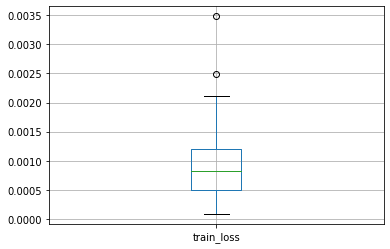

In [27]:
boxplot = df.boxplot(column = ['train_loss'])

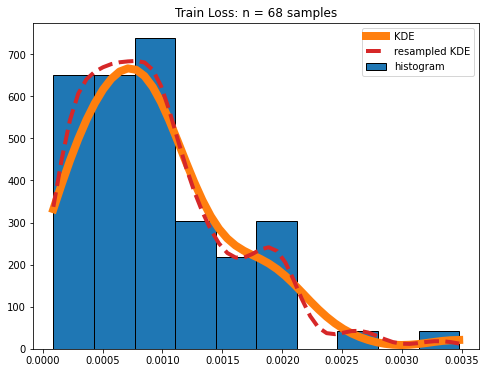

In [28]:
# hist = df.hist(column = ['train_loss'], bins = 10)
# ax = df[['train_loss']].plot.kde()
show_hist_kde_train_loss(bins = 10)

## References

### Compression Algorithms:

- [zlib](http://www.zlib.net/)

### Tutorials:
- [Data To Fish](https://datatofish.com/)

### Statistics Topics:

- [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation)
  - [Stack Overflow Example](https://stackoverflow.com/questions/53823349/how-can-you-create-a-kde-from-histogram-values-only)

### Papers

- [Siren](https://arxiv.org/abs/2006.09661)

### Libraries

- [Standard Python Library](https://docs.python.org/3/library/)
- [Pillow Lib](https://pillow.readthedocs.io/en/stable/index.html)
- [PyTorch Lib](https://pytorch.org/)
- [Pandas Lib](https://pandas.pydata.org/pandas-docs/stable/index.html)

## Citations

@misc{sitzmann2020implicit,
    title={Implicit Neural Representations with Periodic Activation Functions},
    author={Vincent Sitzmann and Julien N. P. Martel and Alexander W. Bergman and David B. Lindell and Gordon Wetzstein},
    year={2020},
    eprint={2006.09661},
    archivePrefix={arXiv},
    primaryClass={cs.CV}
}